## Accessing US Census data with the Planetary Computer STAC API

The [US Census](https://planetarycomputer.microsoft.com/dataset/us-census) collection provides information on population, demographics, and administrative boundaries at various levels of cartographic aggregation for the United States. It consists of many tabular datasets, one for each level of cartographic aggregation, and is stored in [Apache Parquet](https://parquet.apache.org/) format. Parquet can be read by many clients. In this notebook, we'll use geopandas and dask-geopandas to preserve the `geometry` column with administrative boundaries.

In [1]:
import dask_geopandas
import contextily as ctx
import seaborn as sns
import planetary_computer

In [2]:
# TODO: replace with planteray_computer.sign, pystac
credential = planetary_computer.sas.get_token("ai4edataeuwest", "us-census").token
storage_options = {"account_name": "ai4edataeuwest", "credential": credential}

### Read Congressional districts

The `cb_2020_us_cd116_500k.parquet` dataset contains geometries for Congressional Districts for the 166th Congress.

In [3]:
ddf = dask_geopandas.read_parquet(
    "abfs://us-census/2020/cb_2020_us_cd116_500k.parquet",
    storage_options=storage_options,
)
ddf

,STATEFP,CD116FP,AFFGEOID,GEOID,NAMELSAD,LSAD,CDSESSN,ALAND,AWATER,geometry
npartitions=1,,,,,,,,,,
0,category[unknown],int64,object,int64,object,category[unknown],category[unknown],int64,int64,geometry
440,...,...,...,...,...,...,...,...,...,...


We'll select a single district (Maryland's 2nd) and plot it.

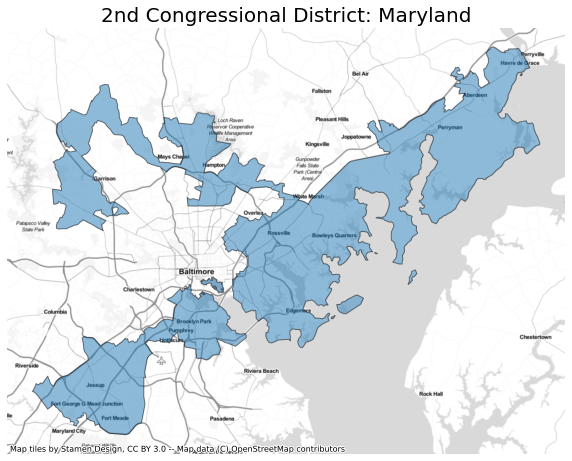

In [4]:
ax = (
    ddf[ddf.GEOID == 2402]
    .compute()
    .to_crs(epsg=3857)
    .plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
)
ax.set_title(
    "2nd Congressional District: Maryland",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

### Read Census Block data

Census blocks are the smallest cartographic unit available from the Census Bureau. There are over 8 million census blocks.

In [5]:
df = dask_geopandas.read_parquet(
    "abfs://us-census/2020/tlgdb_2020_a_us_block.gdb.parq/RI.parq",
    storage_options=storage_options,
).compute()
df

,GEOID,SUFFIX,NAME,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,LOGRECNO,STUSAB,BLOCK,SUMLEV,P0010001,COUNTY
0,440010301001000,None,BLOCK 1000,7996.0,0.0,+41.7652074,-71.3332300,"MULTIPOLYGON (((-7940875.800 5125834.417, -794...",11112.0,RI,1000.0,750.0,19.0,44001
1,440010301001001,None,BLOCK 1001,11821.0,0.0,+41.7644530,-71.3325070,"MULTIPOLYGON (((-7940801.661 5125803.224, -794...",11113.0,RI,1001.0,750.0,12.0,44001
2,440010301001002,None,BLOCK 1002,6001.0,0.0,+41.7650034,-71.3322713,"MULTIPOLYGON (((-7940754.127 5125846.207, -794...",11114.0,RI,1002.0,750.0,25.0,44001
3,440010301001003,None,BLOCK 1003,16049.0,0.0,+41.7638710,-71.3328632,"MULTIPOLYGON (((-7940897.618 5125711.887, -794...",11115.0,RI,1003.0,750.0,36.0,44001
4,440010301001004,None,BLOCK 1004,8264.0,0.0,+41.7643140,-71.3345257,"MULTIPOLYGON (((-7941020.515 5125702.186, -794...",11116.0,RI,1004.0,750.0,25.0,44001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25176,440099901000045,None,BLOCK 0045,0.0,4219491.0,+41.3053283,-71.8949018,"MULTIPOLYGON (((-8004492.996 5057720.169, -800...",NaN,None,NaN,NaN,NaN,44009
25177,440099901000046,None,BLOCK 0046,0.0,634809.0,+41.3063670,-71.8679331,"MULTIPOLYGON (((-8000532.026 5058011.667, -799...",NaN,None,NaN,NaN,NaN,44009
25178,440099901000047,None,BLOCK 0047,0.0,9627021.0,+41.2848718,-71.8743281,"MULTIPOLYGON (((-8004675.226 5057364.811, -800...",NaN,None,NaN,NaN,NaN,44009
25179,440099902000001,None,BLOCK 0001,0.0,109808011.0,+41.2387934,-71.5602069,"MULTIPOLYGON (((-7975235.340 5047500.474, -797...",36759.0,RI,1.0,750.0,0.0,44009


This map gives a sense for the sizes of the census blocks.

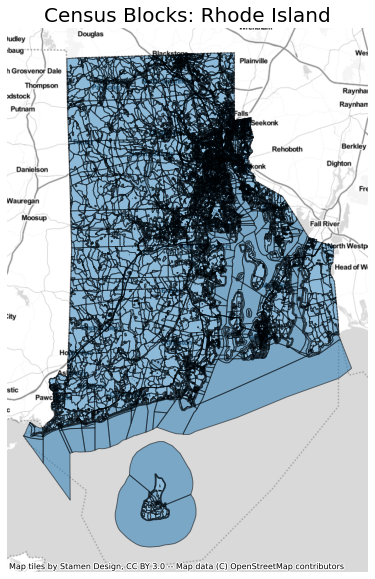

In [6]:
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Census Blocks: Rhode Island",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

Let's filter out the blocks with 0 reported population and plot the distribution of people per census block.

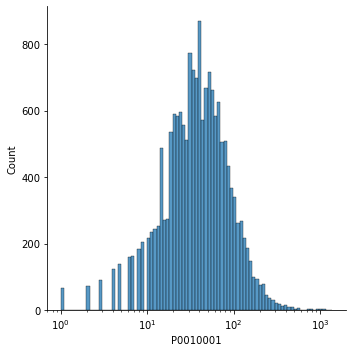

In [7]:
populated = df[df.P0010001 > 0].assign(area=lambda df: df.geometry.area)

sns.displot(populated.P0010001, log_scale=True);

Or we can plot the relationship between the population and the size of the census block.

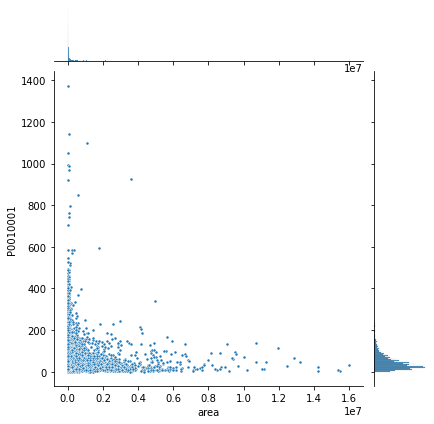

In [8]:
sns.jointplot(x="area", y="P0010001", data=populated, marker=".");

### Next Steps

For more, see the [US Census data tutorial](https://github.com/microsoft/PlanetaryComputerExamples/tree/main/tutorials/census-data.ipynb), which includes examples for accessing data at each level of cartographic aggregation.